In [1]:
%config IPCompleter.greedy = True
%matplotlib inline

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import random 
import time

np.random.seed(42)
random.seed(42)

print(torch.__version__)

1.5.0


In [8]:
#device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

False


In [9]:
def show_images(img):
    img = img.numpy()
    img = np.transpose(img, (1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img*std + mean
    plt.figure(figsize = (20, 10))
    plt.imshow(img)
    plt.show()

In [10]:
def get_train_valid_loaders(root,
                            batch_size,
                            augment,
                            valid_size = 0.2,
                            shuffle = True,
                            num_workers = 2,
                            pin_memory = True
                            ):
    
    randomtransforms = [transforms.ColorJitter(hue=.05, saturation=.05),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)]
    
    if(augment):
        traintransforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomApply(randomtransforms, p = 0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        traintransforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
        
    validtransforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
    
    train_dataset = ImageFolder(root, transform = traintransforms)
    valid_dataset = ImageFolder(root, transform = validtransforms)
    
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    if(shuffle):
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    
    trainiter = iter(train_loader)
    images, labels = next(trainiter)
    show_images(torchvision.utils.make_grid(images))
    print(labels)
    
    return(train_loader, valid_loader, len(train_sampler), len(valid_sampler))    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


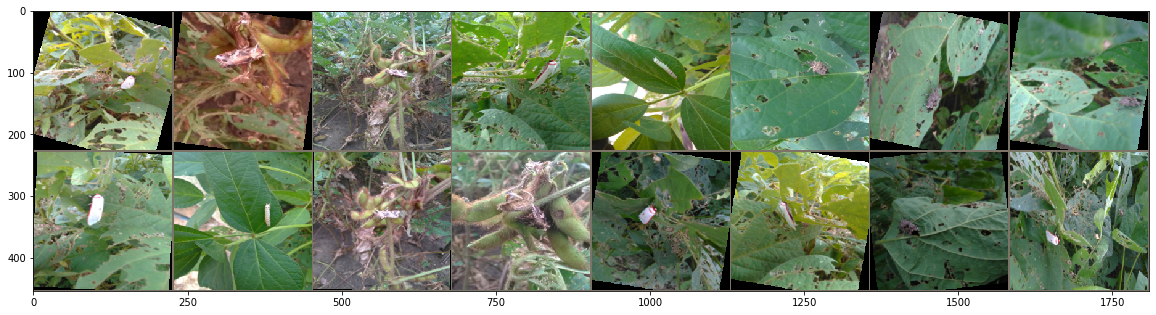

tensor([2, 3, 3, 2, 1, 0, 0, 0, 2, 1, 3, 3, 2, 2, 0, 2])


In [11]:
PATH = "/home/user/Documents/aditya_main/aditya/data/insects"
items = get_train_valid_loaders(root = PATH, batch_size = 16, augment = True, num_workers=64)
train_loader, valid_loader, train_size, val_size = items

In [12]:
def train(model, loaders, criterion, optimizer, scheduler, epochs):
    start = time.time()
    
    train_losses = []
    train_acc = []
    eval_losses = []
    eval_acc = []
    
    train_loader, val_loader = loaders
    
    for epoch in range(epochs):
        print(f'Epoch - {epoch+1}/{epochs}')
        print('-'*20)
        
        for phase in ['train', 'eval']:
            running_loss = 0.0
            running_correct = 0
            
            e_start = time.time()
            
            if phase == 'train':
                model.train()
            
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    
                    outputs = model(inputs)
                    probs = nn.functional.softmax(outputs, dim = 0)

                    loss = criterion(outputs, labels)
                    _, pred = torch.max(probs, dim = 1)
                    
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    running_correct += torch.sum(pred.data == labels.data)

                if scheduler:
                    scheduler.step()
                epoch_loss = running_loss/train_size
                acc = (running_correct.double()/train_size)
                
                train_losses.append(epoch_loss)
                train_acc.append(acc)
            
            else:
                model.eval()
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels =  inputs.to(device), labels.to(device)
                        optimizer.zero_grad()

                        outputs = model(inputs)
                        probs = nn.functional.softmax(outputs, dim = 0)

                        loss = criterion(outputs, labels)
                        _, pred = torch.max(probs, dim = 1)
                        
                        running_loss += loss.item()
                        running_correct += torch.sum(pred == labels.data)                

                        
                epoch_loss = running_loss/val_size
                acc = (running_correct.double()/val_size)
                
                eval_losses.append(epoch_loss)
                eval_acc.append(acc)
                
            e_end = time.time()-e_start
            print(f'{phase} : loss - {epoch_loss:3.2f} acc - {acc:3.2f} , Time - {e_end:.2f}')
        
    end = time.time() - start
    print(f'Training time - {end:.2f}')
    return model, [train_losses, train_acc, eval_losses, eval_acc]

In [13]:
model = torchvision.models.mobilenet_v2(pretrained = True)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 4)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.05)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [14]:
trained_model = train(model, [train_loader, valid_loader], criterion, optimizer, scheduler=None, epochs=15)

Epoch - 1/15
--------------------
train : loss - 0.12 acc - 0.35 , Time - 236.60
eval : loss - 0.08 acc - 0.33 , Time - 33.05
Epoch - 2/15
--------------------
train : loss - 0.07 acc - 0.38 , Time - 253.48
eval : loss - 0.07 acc - 0.54 , Time - 33.35
Epoch - 3/15
--------------------
train : loss - 0.05 acc - 0.48 , Time - 255.91
eval : loss - 0.04 acc - 0.66 , Time - 29.80
Epoch - 4/15
--------------------
train : loss - 0.03 acc - 0.61 , Time - 269.22
eval : loss - 0.05 acc - 0.83 , Time - 32.68
Epoch - 5/15
--------------------
train : loss - 0.02 acc - 0.74 , Time - 245.28
eval : loss - 0.03 acc - 0.77 , Time - 27.32
Epoch - 6/15
--------------------
train : loss - 0.02 acc - 0.80 , Time - 245.65
eval : loss - 0.15 acc - 0.81 , Time - 32.24
Epoch - 7/15
--------------------
train : loss - 0.02 acc - 0.81 , Time - 275.16
eval : loss - 0.02 acc - 0.88 , Time - 34.36
Epoch - 8/15
--------------------
train : loss - 0.01 acc - 0.84 , Time - 248.62
eval : loss - 0.02 acc - 0.85 , Time 

In [15]:
model_tr, metrics = trained_model

In [16]:
model_tr.eval()
example_inputs = torch.rand(1, 3, 224, 224).to(device)
model_traced = torch.jit.trace(model_tr, example_inputs=example_inputs)
model_traced.save('mobilenet_traced_new.pt')

In [ ]:
torch.save(model_tr.state_dict(), 'weights.pt')

In [ ]:
torch.save(model_tr, 'model.pt')

In [17]:
print(torch.version.__version__)

1.5.0
